### 4장 좋은 훈련 세트 만들기: 데이터 전처리
- 4.1 누락된 데이터 다루기
- 4.2 범주형 데이터 다루기
- 4.3 데이터셋을 훈련 세트와 테스트 세트로 나누기
- 4.4 특성 스케일 맞추기
- 4.5 유용한 특성 선택
- 4.6 랜덤 포레스트의 특성 중요도 사용
--- 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

---
#### 1. fillna() : 누락된 값의 대체 
- 특정 값 또는 숫자로 대체하기 : df.fillna(0), df.fillna('값 없음') 
- 이전 행 또는 다음 행의 값으로 대체하기 : df.fillna(method = 'bfill'), df.fillna(method = 'ffill') 
- 통계량의로 대체하기 : df.fillna(df.mean()), df.fillna(df.median()), df.fillna(df.mode()), df.fillna(df.max()) ... 
---

In [2]:
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [3]:
df.fillna(method='bfill')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,12.0,8.0
2,10.0,11.0,12.0,NaN


In [4]:
df.fillna(method='ffill')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,3.0,8.0
2,10.0,11.0,12.0,8.0


--- 
#### 2. categorical 변수의 정수 인코딩 변환 
- sklearn's LabelEncoder 
- pandas's get_dummies
---

In [5]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [6]:
## 원시적인 방법 
df['size'] = df['size'].map({'XL':3, 'L':2, 'M':1})
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [7]:
from sklearn.preprocessing import LabelEncoder
a = LabelEncoder().fit_transform(df['color'].values)
c = LabelEncoder().fit_transform(df['classlabel'].values)

print(a, c)

[1 2 0] [1 0 1]


In [11]:
## size는 순서가 있다고 볼수 있지만, color는 순서가 없다. --> 원-핫 인코딩 필요  
## pandas의 get_dummies 메서드로 간편하게 one-hot 인코딩 : 문자열 컬럼만 변환, 수치형 컬럼은 그대로 유지됨 
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [13]:
## get_dummies에서 특정컬럼을 지정하는 방법 
pd.get_dummies(df[['price', 'color', 'size']], columns = ['size'])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


---
#### 3. train / test dataset split 
---

In [25]:
## wine dataset : class label은 세중류의 다른 와이 포도 품종을 의미함 
df_wine = pd.read_csv('data/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('data size =', df_wine.shape)
print('Class labels =', np.unique(df_wine['Class label']))
df_wine.head()

data size = (178, 14)
Class labels = [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [24]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(124, 13) (54, 13) (124,) (54,)


----
#### 4. 정규화와 표준화 
- 정규화(normalization) : 특성의 스케일을 0~1의 범위에 맞추는 것. 최소-최대 스케일 변환 방법 
- 표준화(standardization) : 특성의 평균을 0, 표준편차를 1로 만들어 정규분포화 하는 것
- **정규화는 min-max scale변환을 통해 정해진 범위의 값을 얻어내는 방법, 표준화는 outlier가 유지되므로 이상치에 덜 민감함 특성 
----

In [26]:
## 정규화 
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)

<AxesSubplot:ylabel='Density'>

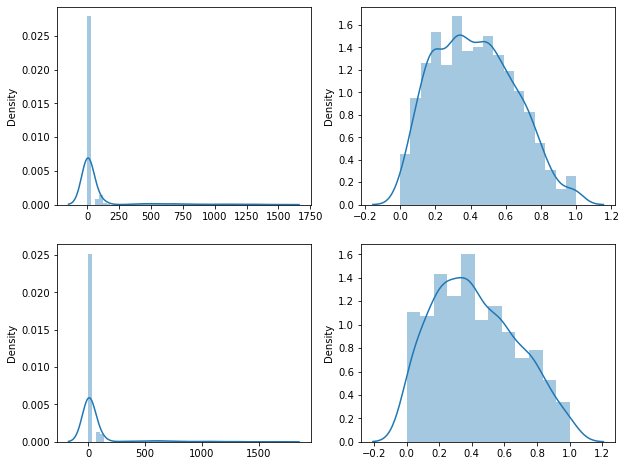

In [30]:
figure, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(10,8)
sns.distplot(X_train, ax=ax1)
sns.distplot(X_train_norm, ax=ax2)
sns.distplot(X_test, ax=ax3)
sns.distplot(X_test_norm, ax=ax4)

In [33]:
## 표준화 
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

<AxesSubplot:ylabel='Density'>

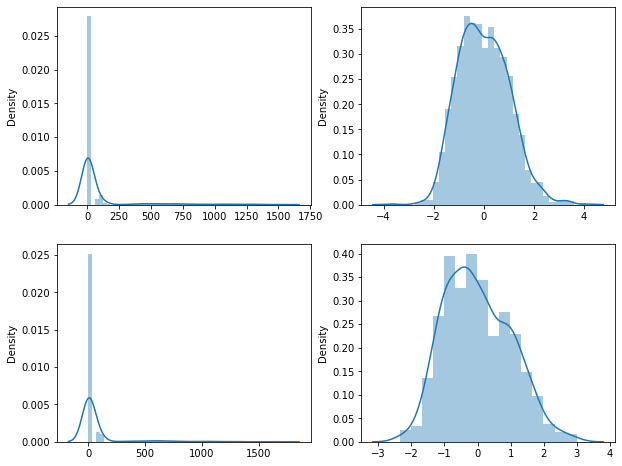

In [34]:
figure, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(10,8)
sns.distplot(X_train, ax=ax1)
sns.distplot(X_train_std, ax=ax2)
sns.distplot(X_test, ax=ax3)
sns.distplot(X_test_std, ax=ax4)

----
#### 5. 모형의 규제 : overfitting 방지를 위한 가중치 제한 방법 
- L1(Lasso) : 가중치의 절대값을 제한하는 방식, 일부 가중치를 0으로-즉 특성을 무력화시키는 특징이 있어 변수선택에도 응용됨 
- L2(Ridge) : 가중치의 제곱합을 제한하는 방식, 일부 가중치들의 영향력을 줄이지만 완전 무력화 시키지는 않음 (underfitting우려가 덜함) 
----

In [40]:
## 일반적으로 L2를 주로 사용하므로, L1 사용을 위해서는 알고리즘과 페널티 값을 지정해줘야 함 
## solver = 'lbfgs', penalty='l2', C=0.1이 default임 
from sklearn.linear_model import LogisticRegression 
lr = LogisticRegression(solver = 'liblinear', penalty = 'l1', C=1, random_state = 42)
lr.fit(X_train_std, y_train)

print('-Train accuracy =', lr.score(X_train_std, y_train))
print('-Test accuracy =', lr.score(X_test_std, y_test))

-Train accuracy = 1.0
-Test accuracy = 0.9814814814814815


In [41]:
lr.coef_

array([[ 1.4258571 ,  0.14010284,  0.70744031, -1.25796659,  0.        ,
         0.        ,  1.39325062,  0.        , -0.05863508,  0.        ,
         0.        ,  0.42494306,  1.98077194],
       [-1.46235813, -0.43959646, -1.21174007,  0.61578455,  0.        ,
         0.        ,  0.        ,  0.        ,  0.64871876, -1.70573341,
         1.22694988,  0.        , -1.98173237],
       [ 0.        ,  0.39741809,  0.32819471,  0.        ,  0.        ,
         0.        , -2.25442411,  0.        , -0.06958236,  1.7131403 ,
        -1.08962747, -0.15704008,  0.        ]])

In [44]:
lr = LogisticRegression(solver = 'liblinear', penalty = 'l1', C=0.1, random_state = 42)
lr.fit(X_train_std, y_train)

print('-Train accuracy =', lr.score(X_train_std, y_train))
print('-Test accuracy =', lr.score(X_test_std, y_test))

-Train accuracy = 0.9838709677419355
-Test accuracy = 0.9814814814814815


In [45]:
lr.coef_

array([[ 0.34223964,  0.        ,  0.        , -0.07390585,  0.        ,
         0.        ,  0.63914306,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23878148],
       [-0.81338591, -0.06188272, -0.08820444,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.89757715,
         0.10174462,  0.        , -0.30826365],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.71654581,  0.        ,  0.        ,  0.44173676,
        -0.47181696, -0.42623243,  0.        ]])

- C=1 --> C=0.1로 규제의 강도를 증가함에 따라, 가중치가 크게 감소(즉 변수 영향력 감소)되었다. 

---
#### 6. Random Forest와 특성 중요도 
- RandomClassifier 훈련 후 feature_importances_ 속성에서 확인 가능 
---

 1) Color intensity                0.162303
 2) Alcohol                        0.151270
 3) Flavanoids                     0.147553
 4) Proline                        0.143969
 5) Hue                            0.097441
 6) OD280/OD315 of diluted wines   0.094434
 7) Total phenols                  0.057177
 8) Magnesium                      0.033139
 9) Malic acid                     0.032247
10) Alcalinity of ash              0.027883
11) Proanthocyanins                0.025907
12) Nonflavanoid phenols           0.013891
13) Ash                            0.012786


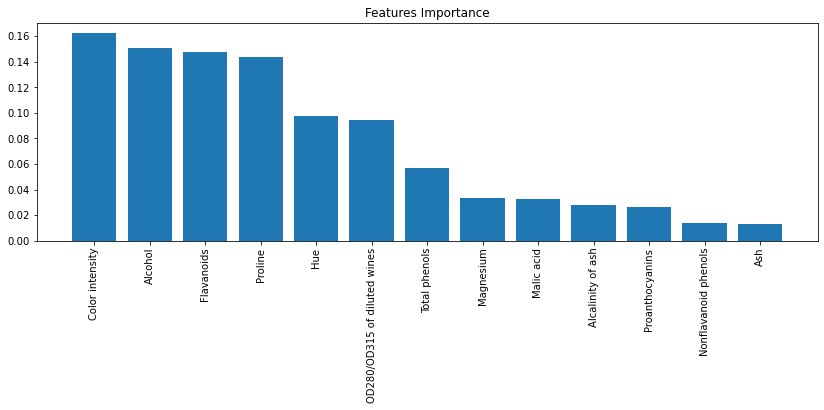

In [85]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 500, random_state = 42)
forest.fit(X_train, y_train)

feat_labels = df_wine.columns[1:]
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]): ## X_train.shape가 (124, 13)이므로, 컬럼수 13개에 대해 ... 
    #print(f+1, feat_labels[indices[f]], importances[indices[f]])
     print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(14, 4))
plt.bar(range(X_train.shape[1]), importances[indices], align = 'center')
plt.title('Features Importance')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation = 90)
plt.show()

In [95]:
## SelectFromModel : RandomForestClasifier으로 학습된 결과로부터, 지정한 임계값 이상 중요도를 가진 특성들을 추출 
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold = 0.1, prefit = True)
X_selected = sfm.transform(X_train)

print( X_selected.shape)
print( X_selected[:5] )

(124, 4)
[[  13.75    2.76    5.6  1320.  ]
 [  13.73    3.25    5.7  1285.  ]
 [  13.28    2.68    4.6   880.  ]
 [  13.58    3.19    6.9  1515.  ]
 [  11.45    2.79    3.25  625.  ]]


In [94]:
## threshold = 0.1 이상인 4개의 특성들만 남았다. 확인해보면 ... 
for f in range(X_selected.shape[1]): 
    print(f+1, feat_labels[indices[f]], importances[indices[f]])

1 Color intensity 0.16230250606837723
2 Alcohol 0.15126999727600815
3 Flavanoids 0.1475528725204502
4 Proline 0.14396891678873674


In [101]:
## cf. 
print(df_wine.columns)
print(forest.feature_importances_) 

Index(['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
       'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')
[0.15127    0.03224729 0.01278566 0.02788292 0.03313906 0.05717745
 0.14755287 0.01389128 0.02590692 0.16230251 0.0974407  0.09443442
 0.14396892]


In [115]:
a = pd.DataFrame(df_wine.columns)
b = pd.DataFrame(forest.feature_importances_)
c = pd.concat([a, b], axis = 1)
c.columns = ['features', 'importances']
c
#c.to_csv('data/importances.csv', index=False)

,features,importances
0,Class label,0.151270
1,Alcohol,0.032247
2,Malic acid,0.012786
3,Ash,0.027883
4,Alcalinity of ash,0.033139
5,Magnesium,0.057177
6,Total phenols,0.147553
7,Flavanoids,0.013891
8,Nonflavanoid phenols,0.025907
9,Proanthocyanins,0.162303
